# Creating a simple forecasting model
Before we can use mosqlient, we need to install the reticulate library in R. If you already have it installed, you can skip the cell below.

In [1]:
install.packages('pak')
library(pak)
pak::pak("rstudio/reticulate")

Installing package into ‘/home/fccoelho/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

! Using bundled GitHub PAT. Please add your own PAT using `gitcreds::gitcreds_set()`.


✔ Updated metadata database: 1.40 MB in 1 file.


ℹ Updating metadata database
✔ Updating metadata database ... done


 

→ Will update 1 package.

→ The package (0 B) is cached.

+ reticulate 1.37.0.9001 → 1.38.0.9000 [bld][cmp] (GitHub: d683b3b) + ✔ python3

✔ All system requirements are already installed.

  

ℹ No downloads are needed, 1 pkg is cached

✔ Got reticulate 1.38.0.9000 (source) (2.03 MB)

ℹ Packaging reticulate 1.38.0.9000

✔ Packaged reticulate 1.38.0.9000 (445ms)

ℹ Building reticulate 1.38.0.9000

✔ Built reticulate 1.38.0.9000 (11.6s)

✔ Installed reticulate 1.38.0.9000 (github::rstudio/reticulate@d683b3b) (36ms)

✔ 1 pkg + 11 deps: kept 7, upd 1, dld 1 (NA B) [18.9s]



In [2]:
library(reticulate)

## Installing Mosqlient

In [3]:
py_install("mosqlient>=1.5.2", envname='r-reticulate')

Using virtual environment 'r-reticulate' ...


+ /home/fccoelho/.virtualenvs/r-reticulate/bin/python -m pip install --upgrade --no-user 'mosqlient>=1.5.2'



In [4]:
mosq <- import("mosqlient")

In [5]:
mosq$version

[1] "1.5.2"

## Downloading the Dengue dataset
Here we will build a simple univariate model using only dengue cases. We could use the Mosqlient library to fetch the data straight from the API, but instead we will download the prepared datasets made available by the sprint organizers. For this you can go to [info.dengue.mat.br/minio](https://info.dengue.mat.br/minio), and download the infodengue dataset. This dataset is a gzip compressed csv file called `dengue.csv.gv` and save it in the same directory as this notebook.

In [6]:
library(data.table)

In [7]:
data = fread("dengue.csv.gz")
tail(data)

date,year,epiweek,casos,geocode,regional,regional_geocode,macroregional,macroregional_geocode,uf,train_1,train_2,target_1,target_2
<IDate>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>
2024-06-02,2024,202423,0,2907202,Juazeiro,29016,Norte,2913,BA,FALSE,FALSE,FALSE,TRUE
2024-06-02,2024,202423,0,2902401,Itabuna,29012,Sul,2910,BA,FALSE,FALSE,FALSE,TRUE
2024-06-02,2024,202423,0,2903409,Porto Seguro,29018,Extremo Sul,2916,BA,FALSE,FALSE,FALSE,TRUE
2024-06-02,2024,202423,0,2904753,Ibotirama,29008,Oeste,2912,BA,FALSE,FALSE,FALSE,TRUE
2024-06-02,2024,202423,0,2906907,Teixeira de Freitas,29026,Extremo Sul,2916,BA,FALSE,FALSE,FALSE,TRUE
2024-06-02,2024,202423,0,2908903,Feira de Santana,29006,Centro-Leste,2917,BA,FALSE,FALSE,FALSE,TRUE


## Creating a simple Forecast model
Let's for the sake of this example fit the dengue series for the state of Rio de Janeiro (UF="RJ"). For this we need to aggregate the cases from all 92 municipalities of the state.

The first challenge is to forecast 22/23 season using previous data. 

In [8]:
library(forecast)
library(tidyverse)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks s

Let's for the sake of this example let us fit the series for the state of Rio de Janeiro (UF="RJ"). For this we need to aggregate the cases from all 92 municipalities of the state.

In [9]:
dRJ.train <- data %>%
  filter(train_1) %>%
  filter(uf == "RJ") %>% 
  group_by(date) %>% 
  summarize(casos=sum(casos)) %>% 
  arrange(date)

In [10]:
dRJ.target <- data %>%
  filter(target_1) %>%
  filter(uf == "RJ") %>% 
  group_by(date) %>% 
  summarize(casos=sum(casos)) %>% 
  arrange(date)

First, creating time series objects

In [11]:
ts.train <- ts(dRJ.train$casos, start = c(2010, 01), frequency = 52)
ts.target <- ts(dRJ.target$casos, start = c(2022, 41), frequency = 52)

Plotting the challenge

Warning message in ggplot2::geom_line(na.rm = TRUE, ...):
“Ignoring unknown parameters: `xlim`”
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


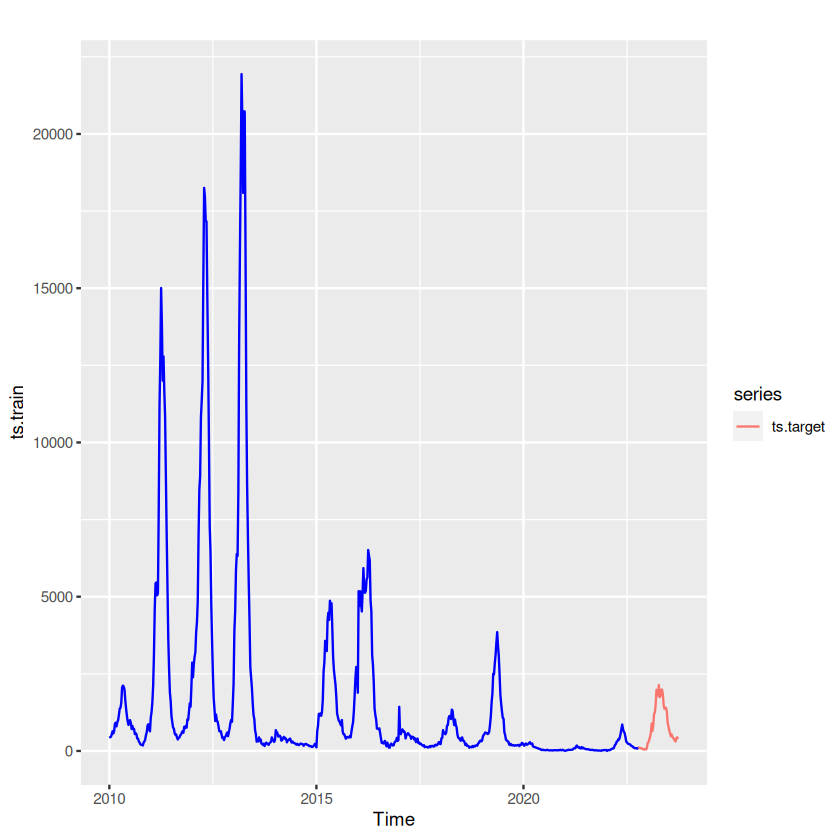

In [12]:
autoplot(ts.train, colour="blue", xlim = as.Date(c("2010-01-01","2023-10-01")))+
  autolayer(ts.target)

Training the (very bad) arima model

In [13]:
fit.train = auto.arima(ts.train)
summary(fit.train)

Series: ts.train 
ARIMA(3,1,5) 

Coefficients:
         ar1     ar2      ar3      ma1      ma2     ma3     ma4      ma5
      0.9075  0.7970  -0.7622  -0.3957  -1.1697  0.4825  0.3090  -0.2137
s.e.  0.0564  0.0832   0.0512   0.0660   0.0697  0.0666  0.0452   0.0453

sigma^2 = 259805:  log likelihood = -5086.29
AIC=10190.58   AICc=10190.85   BIC=10231.08

Training set error measures:
                    ME     RMSE      MAE       MPE     MAPE      MASE
Training set -9.257656 506.2554 233.5527 -29.21083 39.42802 0.1434097
                    ACF1
Training set 0.003769391

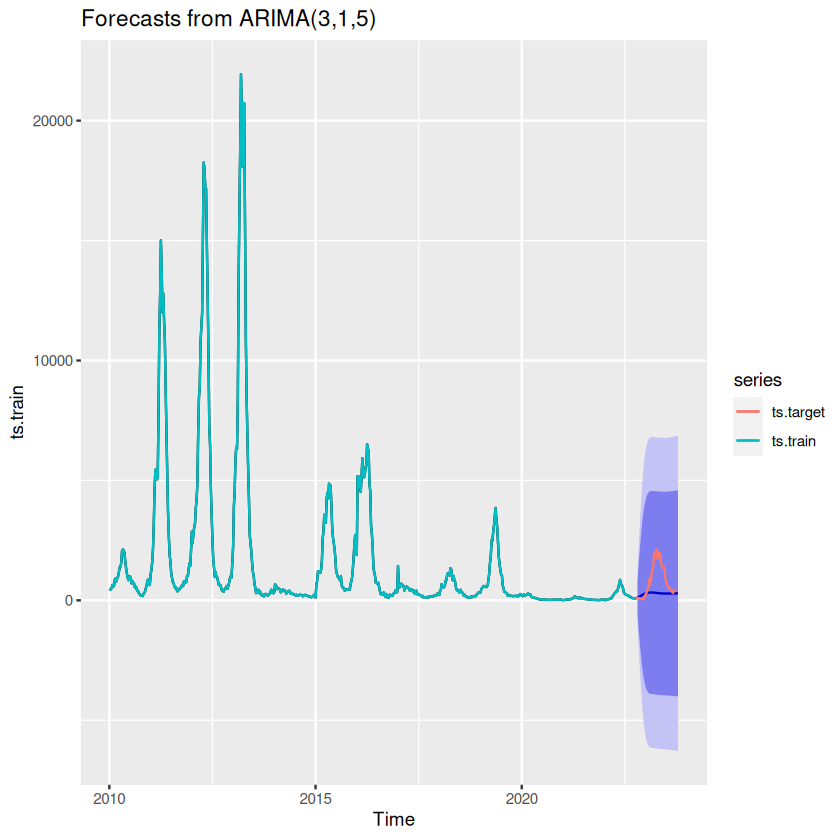

In [14]:
autoplot(forecast(fit.train,h=52))+
autolayer(ts.train) + 
  autolayer(ts.target)

## Preparing the output for uploading

First, register your model in the platform. You will need to have your API key to perform this step. Check the README of this repository to learn how to find it.

In [50]:
library(httr)
url <- "https://api.mosqlimate.org/api/registry/models/"
key = c("your key")
names(key) <- 'X-UID-Key'
model <- list(
    name = "autoarima",
    description = "demo",
    repository = "https://github.com/Mosqlimate-project/sprint-template/",
    implementation_language = "R",
    disease = "dengue",  
    spatial = FALSE,
    temporal = TRUE,
    categorical = FALSE,
    ADM_level = 1,
    time_resolution = "week"
  )
response <- POST(url, body = model, add_headers(.headers=key),  encode = "json")
response

Response [https://api.mosqlimate.org/api/registry/models/]
  Date: 2024-06-25 14:19
  Status: 401
  Content-Type: application/json; charset=utf-8
  Size: 64 B


This request failed with status 401, because I did not use my API key. But when you do it for real, with your model's details and your API key, you will get a successful POST with a 201 status.

Now, to upload your prediction, you need: 
1. the id number of your model, see instructions in the GitHub README
2. dataframe with the following columns: 

- date(YYYY-mm-dd): same used in the dataset
- preds (num): point estimates
- lower (num): 95% lower interval
- upper (num): 95% upper interval
- adm_1 (two letters string): UF code (example: "RJ")
- adm_2: NA  
- adm_3: NA

In [14]:
uf = "RJ"  # change that accordingly to your data
x <- data.frame(forecast(fit.train,h=52))[,c("Point.Forecast","Lo.95","Hi.95")] 
x <- x %>%
  mutate(dates = as.Date(date_decimal(as.numeric(row.names(x)))),
         adm_1 = uf, 
         adm_2 = NA,
         adm_0 = NA) %>%
  select(dates, 
         preds = Point.Forecast,
         lower = Lo.95,
         upper = Hi.95,
         adm_1,
         adm_2,
         adm_0) %>%
  remove_rownames()

head(x)

,dates,preds,lower,upper,adm_1,adm_2,adm_0
,<date>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>
1,2022-10-22,12.99305,-985.6901,1011.676,RJ,NA,NA
2,2022-10-29,28.33185,-1781.9574,1838.621,RJ,NA,NA
3,2022-11-05,44.00407,-2372.9138,2460.922,RJ,NA,NA
4,2022-11-12,62.41854,-2958.6652,3083.502,RJ,NA,NA
5,2022-11-20,81.46505,-3539.6309,3702.561,RJ,NA,NA
6,2022-11-26,101.47882,-4058.6475,4261.605,RJ,NA,NA


Converting to JSON

In [18]:
library(jsonlite)

y <- toJSON(x, na='string')
y

[{"dates":"2022-10-22","preds":12.9931,"lower":-985.6901,"upper":1011.6762,"adm_1":"RJ","adm_2":"NA","adm_0":"NA"},{"dates":"2022-10-29","preds":28.3319,"lower":-1781.9574,"upper":1838.6211,"adm_1":"RJ","adm_2":"NA","adm_0":"NA"},{"dates":"2022-11-05","preds":44.0041,"lower":-2372.9138,"upper":2460.922,"adm_1":"RJ","adm_2":"NA","adm_0":"NA"},{"dates":"2022-11-12","preds":62.4185,"lower":-2958.6652,"upper":3083.5023,"adm_1":"RJ","adm_2":"NA","adm_0":"NA"},{"dates":"2022-11-20","preds":81.465,"lower":-3539.6309,"upper":3702.561,"adm_1":"RJ","adm_2":"NA","adm_0":"NA"},{"dates":"2022-11-26","preds":101.4788,"lower":-4058.6475,"upper":4261.6052,"adm_1":"RJ","adm_2":"NA","adm_0":"NA"},{"dates":"2022-12-03","preds":120.7836,"lower":-4530.4955,"upper":4772.0627,"adm_1":"RJ","adm_2":"NA","adm_0":"NA"},{"dates":"2022-12-10","preds":139.7341,"lower":-4927.5599,"upper":5207.0281,"adm_1":"RJ","adm_2":"NA","adm_0":"NA"},{"dates":"2022-12-18","preds":157.0606,"lower":-5266.7497,"upper":5580.871,"adm_

Now, to upload the prediction we will use the `mosqlient` library to handle the POST, instead of the way we did for the model's registration. This will make things substantially easier. For this step you need your *model's id number* found in your profile page in the mosqlimate API website, and collect the commit number of the version of the code at the time of the prediction's generation. 

In [19]:
mosq$upload_prediction(
    model_id=15,
    description="arima forecast for RJ",
    commit="505d1b01a5d9ae59a62e635224244c93eef1a466",
    predict_date="2024-06-25",
    prediction=y,
    api_key="your key"
)

<Response [201]>